In [1]:
# import csv                      # read and write CSV file-type
from enum import Enum           # allows for the creation of enumeration object-types
# import math                     # use math library functions such as 

############## PLOTTING ###############
# needed to make plots editable in the notebook
%matplotlib notebook        
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3

import numpy as np
from numpy.random import PCG64  # random number seed generator based on PCG64 
import time                     # use OS clock

######## IMPORT MY OWN MODULES ########
from sim_loop import *          # import the simulator loop 
from drawRobot import *         # import code that plots the vehicle and arm extension
from plotStates import *        # import module to plot percent time each arm spends in each of the six states
from simulation_config import * # import the JSON creation module to create the settings for each simulator run

######### READ AND WRITE JSON #########
# import json                   # configuration json file encode and decode
# see https://realpython.com/python-json/#decoding-custom-types

######## TESTING AND DEBUGGING ########
# Example: https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
# import unittest             # docs https://docs.python.org/3/library/unittest.html 
# import pdb #; pdb.set_trace() # docs https://docs.python.org/3/library/pdb.html

######## RANDOM SEED GENERATOR ########
# see rand_seed.py for implementation and existing seeds

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
## Flag setting values
class spaceConf(Enum):
    '''Flag values for if the workspace in each row is individual or shared'''
    INDIVIDUAL = 0
    SHARED     = 1

class calendar(Enum):
    '''Flag values for the type of scheduler to use, name seems like a bad idea :P'''
    SINGLE_FRUIT = 0
    EDF          = 1 # Earliest Deadline First, batch

class treeCreation(Enum):
    '''Flags values for the type of data being used as fruit coordinates'''
    CSV_RAJ  = 0
    SYN_LINE = 1
    UNIFORM  = 2

class noiseMaker(Enum):
    TURN_OFF = 0
    TURN_ON  = 1

class reality(Enum):
    '''Flag values determining how many fruit are real and how many are fake in the simulation'''
    TURN_OFF  = 0
    DENSITY   = 1

In [24]:
'''Used to test the simulator and modules being exported from this code'''
# init configuration module and create JSON config file
json_data = simulation_config()
# set to fruit-by-fruit scheduling
# json_data.appointment = calendar.SINGLE_FRUIT
json_data.v_vy  = 0.1
json_data.max_v = 3 

json_data.convertJSON()

# run the simulator with current values
sim = sim_loop()
print()

sim.sysData()
print()
sim.results() # just calculates all the results, doesn't print anything out. 


program took: 9.51 sec
total internal time: 260.00 sec
total vehicle distance moved: 26.50 ft

vehicle speed (if constant) in the y-axis: 0.10 ft/s
max arm velocity: 3 ft/s, max arm acceleration: 10.0 ft/s^2
total number of fruit in CSV file: 675



total real reachable fruit: 675  and reached fruit: 591
percent reachable fruit picked:                     87.56 %

Avergage picking cycle for the system:              3.07 sec
Average number of goals reach for the whole system: 80.62 goals

vehicle y-coordinate velocity: 0.10 ft/s
arm max velocity: 3 ft/s and max acceleration: 10.0 ft/s^2

Seconds per picked fruit per arm [3.880597014924008, 4.406779661015399, 3.9393939393925534, 3.2098765432087473, 3.9393939393925534, 4.406779661015399, 4.482758620688078, 3.880597014924008, 3.823529411763361] sec/fruit

Seconds per picked fruit per row [1.3541666666661902, 1.262135922329653, 1.3471502590668836] sec/fruit

System-wide seconds per picked fruit: 0.44 sec/fruit



<IPython.core.display.Javascript object>


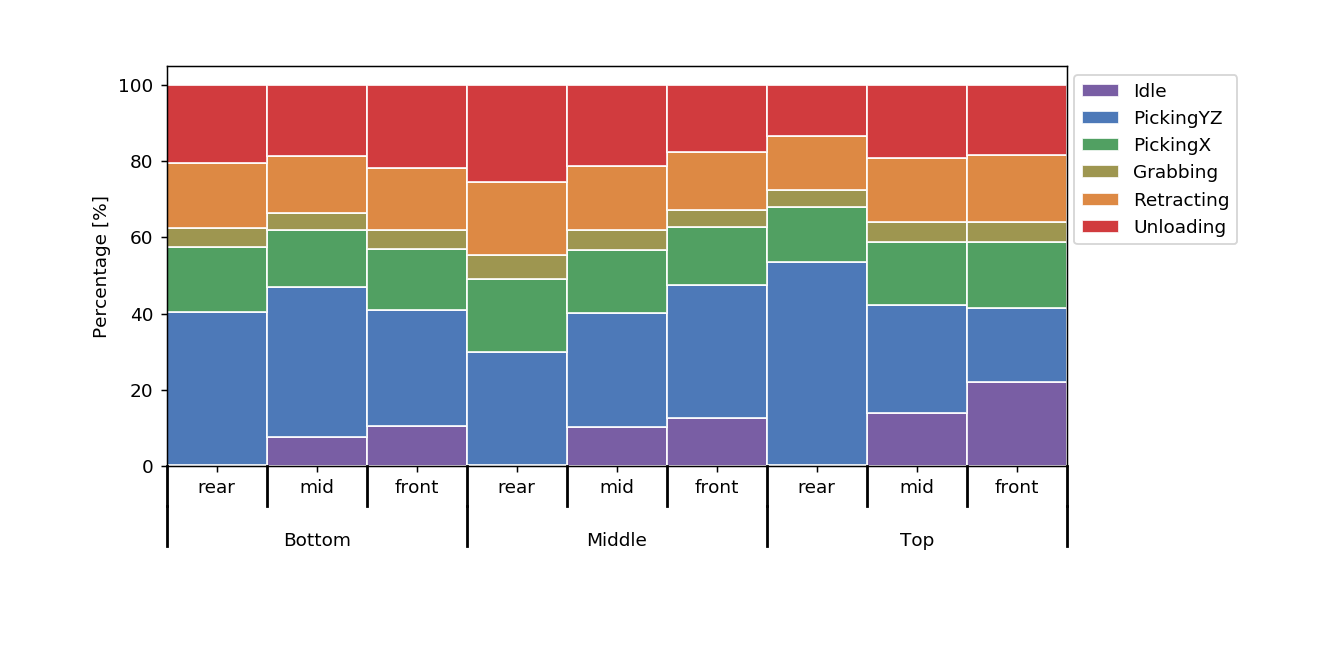

In [25]:
#### STATISTICS! ####
'''Just an example of what is calculated in results()'''

print("total real reachable fruit:", sim.fruit.tot_fruit, " and reached fruit:", sim.total_fruit_picked)
print("percent reachable fruit picked:                     {0:.2f}".format(sim.all_percent_harvest*100), "%" )
print()
print("Avergage picking cycle for the system:              {0:.2f}".format(sim.all_PCT), "sec")
print("Average number of goals reach for the whole system: {0:.2f}".format(sim.all_percent_goal), "goals") # reached goals
print()

print("vehicle y-coordinate velocity: {0:.2f}".format(sim.v_vy), "ft/s")
print("arm max velocity:", sim.max_v, "ft/s and max acceleration:", sim.max_a, "ft/s^2")
print()

print("Seconds per picked fruit per arm", sim.sec_per_fruit, "sec/fruit")
print("")
print("Seconds per picked fruit per row", sim.row_sec_per_fruit, "sec/fruit")
print("")
print("System-wide seconds per picked fruit: {0:.2f}".format(sim.all_sec_per_fruit), "sec/fruit")
print("")

# Plot the percent time each arm spend in each state 
state_plot = plotStates(sim)


<IPython.core.display.Javascript object>


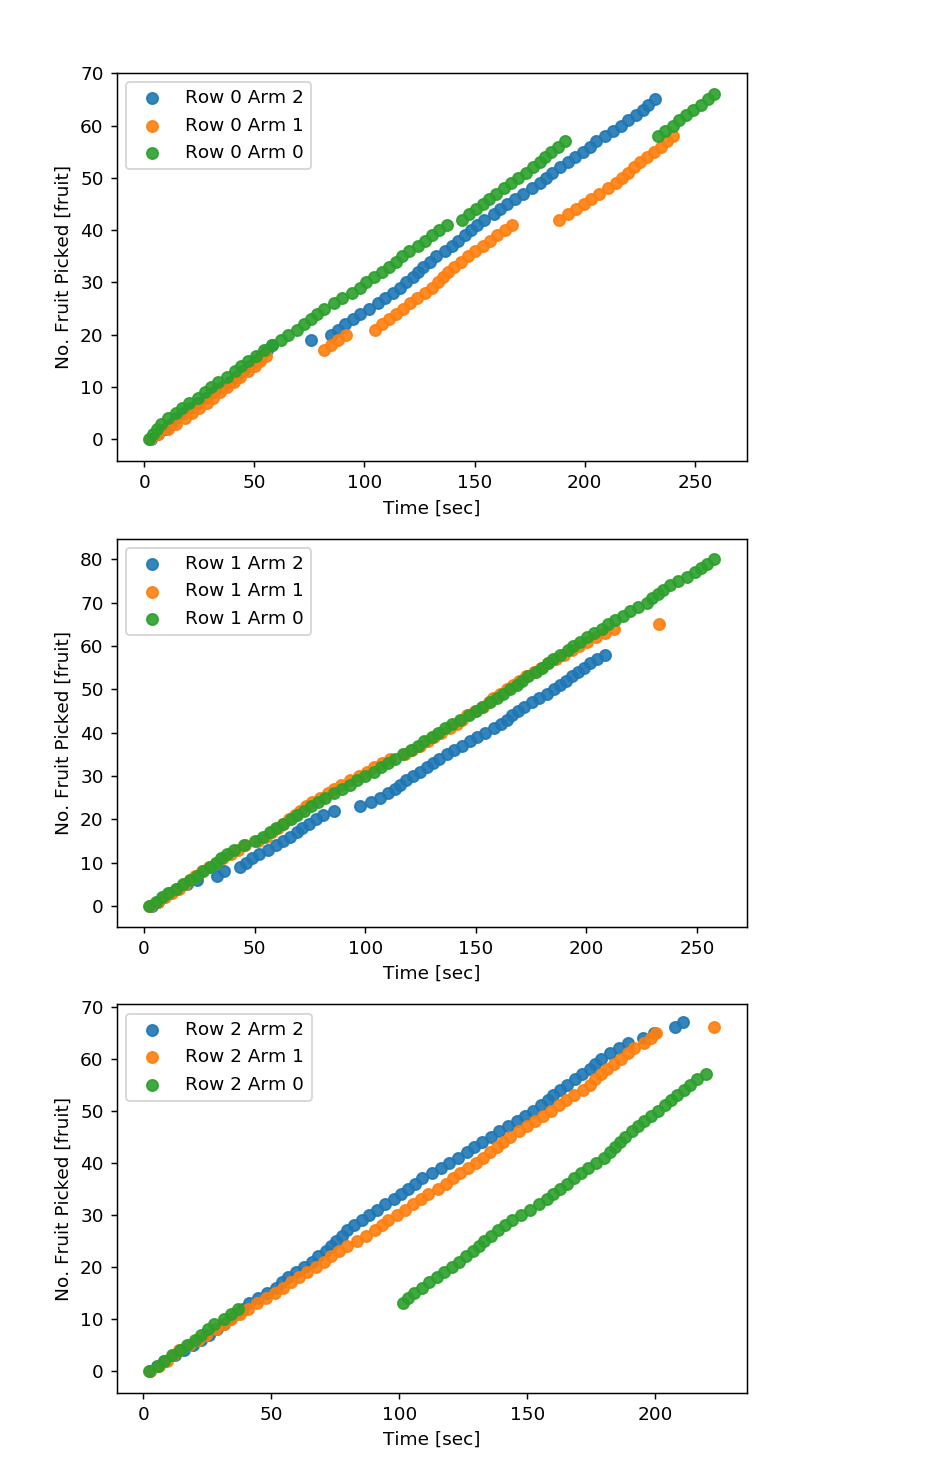

In [26]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(sim.num_row, figsize=(7, 11))

for rows in range(sim.num_row):
    for manipulators in range((sim.num_arms-1), -1, -1):
        time_apples = np.copy(sim.arm_obj[rows,manipulators].pickData())
        apples      = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [31]:
# learn to change variables and get new results. Starting with vehicle velocity :)
# json_data.appointment = calendar.SINGLE_FRUIT
# json_data.convertJSON()

json_data.changeV_v(0.05) # should also create a new json config file that sim_loop can open

# re-init sim_loop
sim = sim_loop()
print()

sim.sysData()
print()
sim.results() # just calculates all the results, doesn't print anything out.


program took: 19.72 sec
total internal time: 520.01 sec
total vehicle distance moved: 26.50 ft

vehicle speed (if constant) in the y-axis: 0.05 ft/s
max arm velocity: 3 ft/s, max arm acceleration: 10.0 ft/s^2
total number of fruit in CSV file: 675



total real reachable fruit: 675  and reached fruit: 540
percent reachable fruit picked:                     80.00 %

Avergage picking cycle for the system:              3.05 sec
Average number of goals reach for the whole system: 70.21 goals

vehicle y-coordinate velocity: 0.05 ft/s
arm max velocity: 3 ft/s and max acceleration: 10.0 ft/s^2


System-wide seconds per picked fruit: 0.96 sec/fruit



<IPython.core.display.Javascript object>


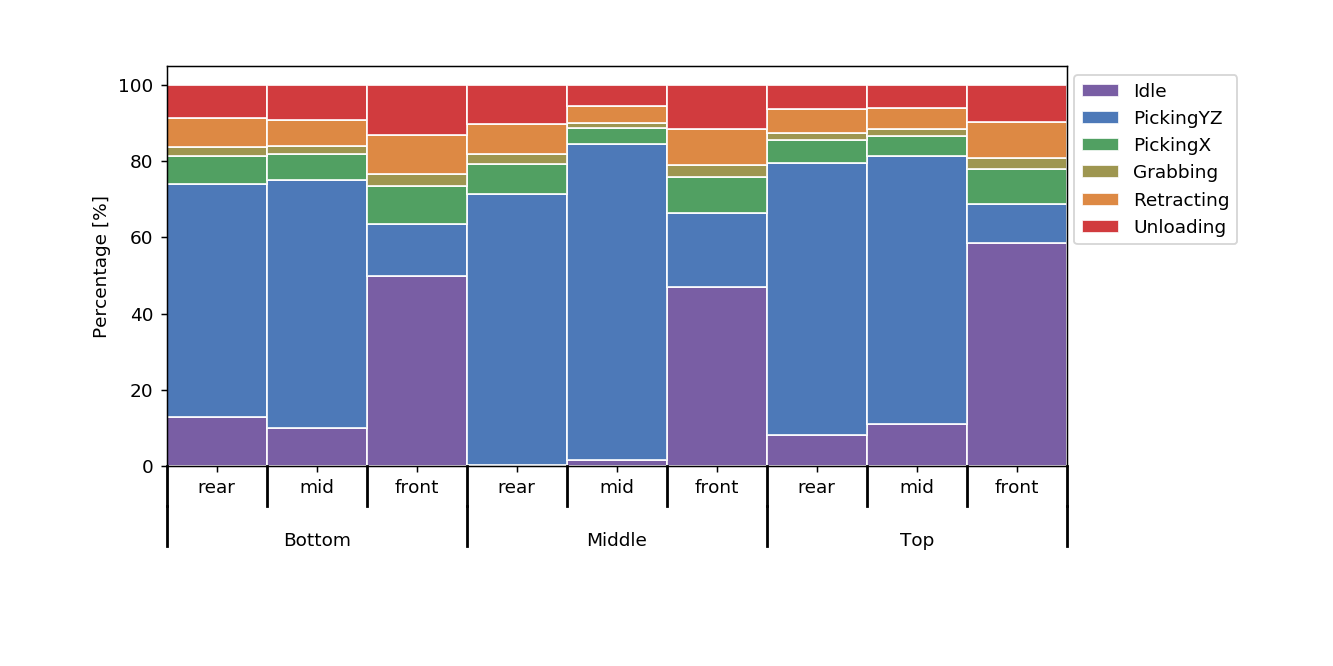

In [32]:
#### STATISTICS! ####
'''Just an example of what is calculated in results()'''

print("total real reachable fruit:", sim.fruit.tot_fruit, " and reached fruit:", sim.total_fruit_picked)
print("percent reachable fruit picked:                     {0:.2f}".format(sim.all_percent_harvest*100), "%" )
print()
print("Avergage picking cycle for the system:              {0:.2f}".format(sim.all_PCT), "sec")
print("Average number of goals reach for the whole system: {0:.2f}".format(sim.all_percent_goal), "goals") # reached goals
print()

print("vehicle y-coordinate velocity: {0:.2f}".format(sim.v_vy), "ft/s")
print("arm max velocity:", sim.max_v, "ft/s and max acceleration:", sim.max_a, "ft/s^2")
print()

# print("Seconds per picked fruit per arm", sim.sec_per_fruit, "sec/fruit")
# print("")
# print("Seconds per picked fruit per row", sim.row_sec_per_fruit, "sec/fruit")
print("")
print("System-wide seconds per picked fruit: {0:.2f}".format(sim.all_sec_per_fruit), "sec/fruit")
print("")

# Plot the percent time each arm spend in each state 
state_plot = plotStates(sim)

<IPython.core.display.Javascript object>


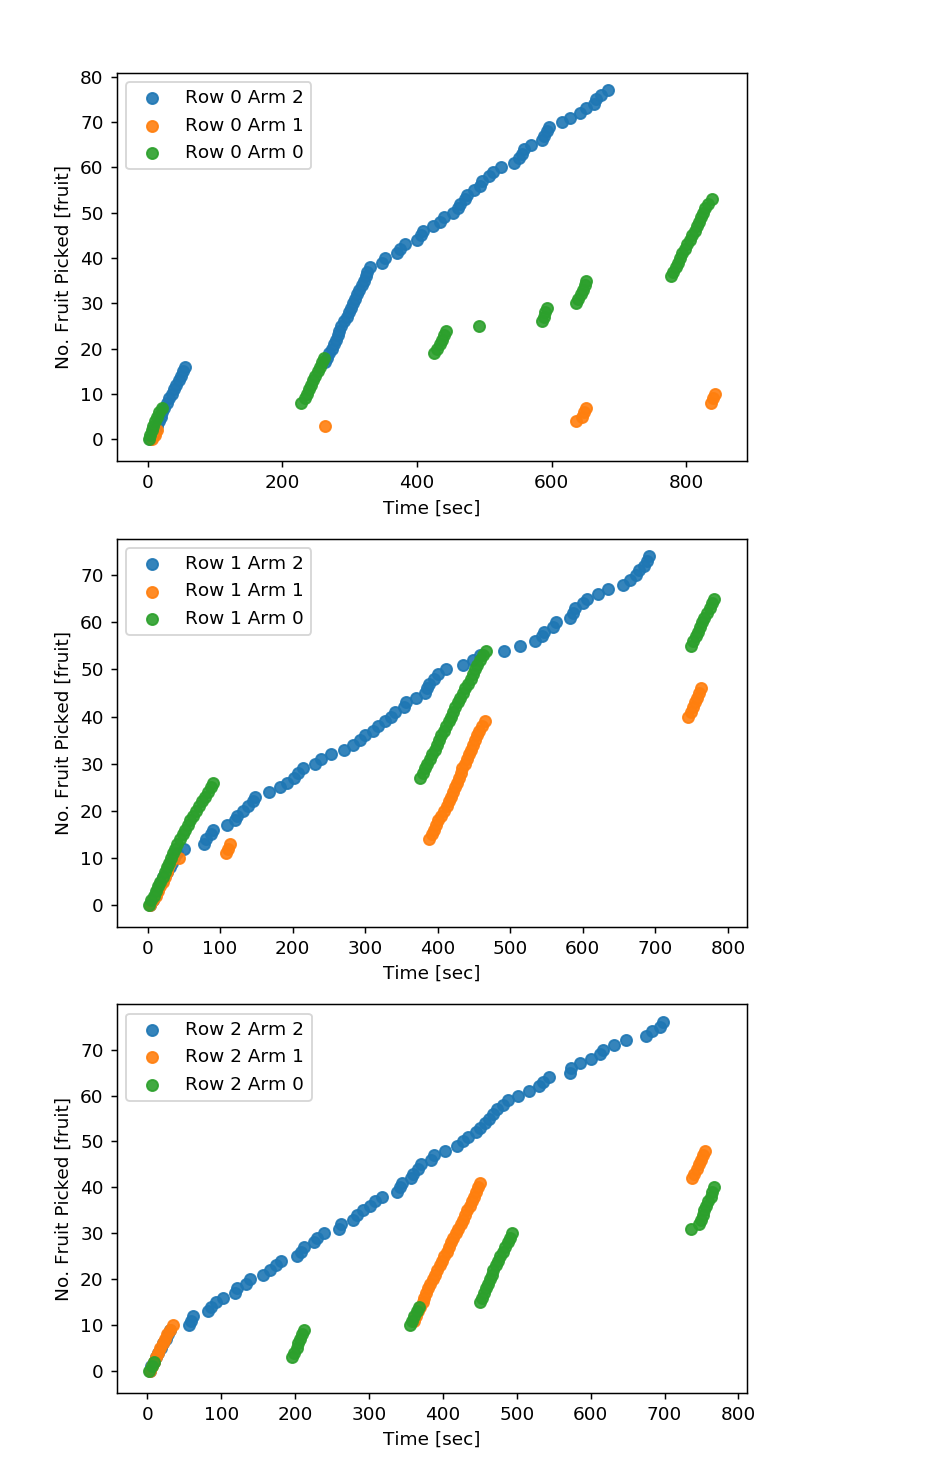

In [30]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(sim.num_row, figsize=(7, 11))

for rows in range(sim.num_row):
    for manipulators in range((sim.num_arms-1), -1, -1):
        time_apples = np.copy(sim.arm_obj[rows,manipulators].pickData())
        apples      = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()

num runs 86667


<IPython.core.display.Javascript object>


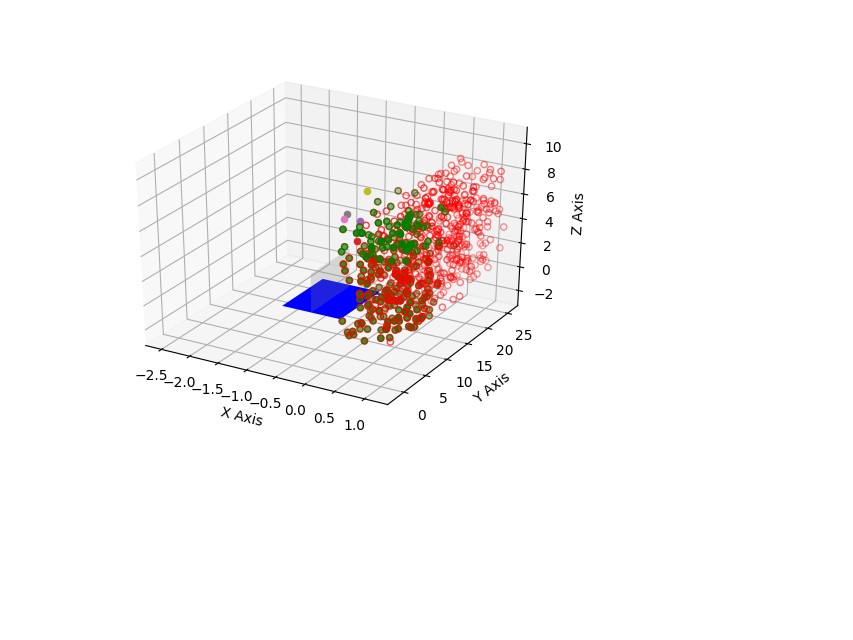

KeyboardInterrupt: 

In [11]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", sim.runs)

dr = drawRobot()

fruit_removal = []
index_rem = []

for rows in range(sim.num_row):
    fruit_removal.append(sim.row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(sim.runs):
    time_of_loop = sim.t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(sim.num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(sim.fruit.sortedFruit[0,:], sim.fruit.sortedFruit[1,:], sim.fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(sim.num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [sim.qv0[run], sim.qv1[run]]
        dr.drawRect(ax, q_vehicle, sim.width_v, sim.length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(ax, sim.left_edge[run], sim.back_edge[run], sim.front_edge[run], sim.arm_obj[0,0].z_edges_f)
    
        # draw cyliders for the extending arms
        for rows in range(sim.num_row):
            for count in range(sim.num_arms):
                ax.scatter(sim.arm_obj[rows,count].qax[run], sim.arm_obj[rows,count].qay[run], sim.arm_obj[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(sim.arm_obj[rows,count].qay[run], sim.arm_obj[rows,count].qaz[run], sim.arm_obj[rows,count].q_f[0], sim.arm_obj[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(sim.fruit_row_ed-3, sim.fruit_row_tk)
        ax.set_zlim(sim.fruit_row_bt-3, sim.fruit_row_tp+2)
        
        ax.set_ylim(sim.fruit_row_st-3, sim.fruit_row_end+2)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
fig.show()

